<a href="https://colab.research.google.com/github/DimitrisLianos/DL/blob/main/DCGAN_Face%20expression_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
from keras.models import Model, load_model # for assembling a Neural Network model
from keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Flatten, Dropout # for adding layers
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, ReLU, LeakyReLU # for adding layers
from tensorflow.keras.optimizers import Adam # for model optimization 

# Data manipulation
import numpy as np # for data manipulation

# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for data visualization

# Other utilities
import os
import cv2
!pip install rarfile
from rarfile import RarFile

# Assign main directory to a variable
main_dir=os.path.dirname(os.path.abspath('__file__'))

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Extract .rar file
with RarFile('/content/drive/MyDrive/Colab Notebooks/GAN face generation model with sentiment parameters/train.rar', 'r') as rar_ref:
    rar_ref.extractall('/content/train')
 



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#TEST

Shape of X_train:  (28821, 28, 28)
Shape of y_train:  (28821,)


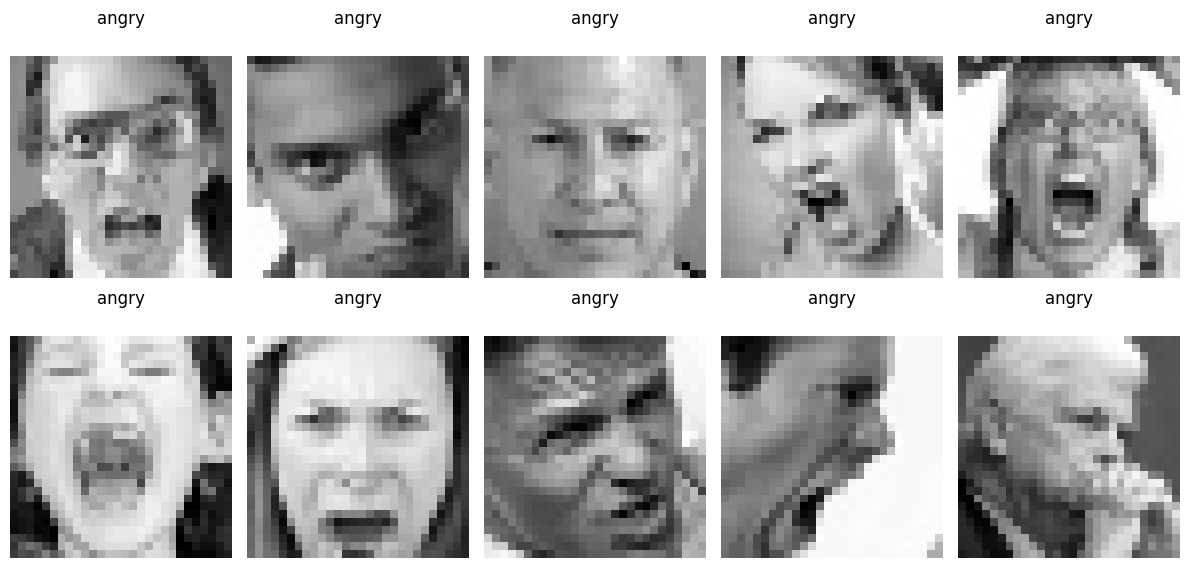

Shape of the scaled array:  (28821, 28, 28, 1)


In [98]:
from tensorflow.python.ops.gen_array_ops import reshape
# Load digits data
train_path = '/content/train/train'
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
X_train = []
y_train = []
for i, category in enumerate(categories):
    category_path = os.path.join(train_path, category)
    images = os.listdir(category_path)
    for image in images:
        image_path = os.path.join(category_path, image)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (28, 28))  # Resize the image to 28x28
        X_train.append(img)
        y_train.append(i)
X_train = np.array(X_train)
y_train = np.array(y_train)

# Print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

# Display images of the first 10 faces in the training set and their true labels
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_train[n], cmap='gray')
        axs[i,j].set(title=categories[y_train[n]])
        axs[i,j].axis('off')
        n=n+1
plt.show()

# Scale and reshape as required by the model
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)  # Reshape to (num_samples, 28, 28, 1)
X_train = (X_train - 127.5) / 127.5  # Normalize the images to [-1, 1]
print("Shape of the scaled array: ", X_train.shape)


In [99]:
def generator(latent_dim, in_shape=(7,7,1), n_cats=7):
        
    # Label Inputs
    in_label = Input(shape=(1,), name='Generator-Label-Input-Layer') # Input Layer
    lbls = Embedding(n_cats, 50, name='Generator-Label-Embedding-Layer')(in_label) # Embed label to vector
    
    # Scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Generator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Generator-Label-Reshape-Layer')(lbls) # New shape

    # Generator Inputs (latent vector)
    in_latent = Input(shape=latent_dim, name='Generator-Latent-Input-Layer')
    
    # Image Foundation 
    n_nodes = 7 * 7 * 128 # number of nodes in the initial layer
    g = Dense(n_nodes, name='Generator-Foundation-Layer')(in_latent)
    g = ReLU(name='Generator-Foundation-Layer-Activation-1')(g)
    g = Reshape((in_shape[0], in_shape[1], 128), name='Generator-Foundation-Layer-Reshape-1')(g)
    
    # Combine both inputs so it has two channels
    concat = Concatenate(name='Generator-Combine-Layer')([g, lbls])

    # Hidden Layer 1
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-1')(concat)
    g = ReLU(name='Generator-Hidden-Layer-Activation-1')(g)
    
    # Hidden Layer 2
    g = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2')(g)
    g = ReLU(name='Generator-Hidden-Layer-Activation-2')(g)
    
    # Output Layer (Note, we use only one filter because we have a greysclae image. Color image would have three
    output_layer = Conv2D(filters=1, kernel_size=(7,7), activation='tanh', padding='same', name='Generator-Output-Layer')(g)
    
    # Define model
    model = Model([in_latent, in_label], output_layer, name='Generator')
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()


Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Generator-Latent-Input-Layer (  [(None, 100)]       0           []                               
 InputLayer)                                                                                      
                                                                                                  
 Generator-Label-Input-Layer (I  [(None, 1)]         0           []                               
 nputLayer)                                                                                       
                                                                                                  
 Generator-Foundation-Layer (De  (None, 6272)        633472      ['Generator-Latent-Input-Layer[0]
 nse)                                                            [0]']                    

In [250]:
def discriminator(in_shape=(28,28,1), n_cats=7):
    
    # Label Inputs
    in_label = Input(shape=(1,), name='Discriminator-Label-Input-Layer') # Input Layer
    lbls = Embedding(n_cats, 50, name='Discriminator-Label-Embedding-Layer')(in_label) # Embed label to vector
    
    # Scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1] 
    lbls = Dense(n_nodes, name='Discriminator-Label-Dense-Layer')(lbls)
    lbls = Reshape((in_shape[0], in_shape[1], 1), name='Discriminator-Label-Reshape-Layer')(lbls) # New shape

    # Image Inputs
    in_image = Input(shape=in_shape, name='Discriminator-Image-Input-Layer')
    
    # Combine both inputs so it has two channels
    concat = Concatenate(name='Discriminator-Combine-Layer')([in_image, lbls])

    # Hidden Layer 1
    h = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-1')(concat)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1')(h)
    
    # Hidden Layer 2
    h = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-2')(h)
    h = LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2')(h)
    h = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name='Discriminator-MaxPool-Layer-2')(h) # Max Pool
    
    # Flatten and Output Layers
    h = Flatten(name='Discriminator-Flatten-Layer')(h) # Flatten the shape
    h = Dropout(0.2, name='Discriminator-Flatten-Layer-Dropout')(h) # Randomly drop some connections for better generalization
   
    output_layer = Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')(h) # Output Layer
    
    # Define model
    model = Model([in_image, in_label], output_layer, name='Discriminator')
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()


Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Discriminator-Label-Input-Laye  [(None, 1)]         0           []                               
 r (InputLayer)                                                                                   
                                                                                                  
 Discriminator-Label-Embedding-  (None, 1, 50)       350         ['Discriminator-Label-Input-Layer
 Layer (Embedding)                                               [0][0]']                         
                                                                                                  
 Discriminator-Label-Dense-Laye  (None, 1, 784)      39984       ['Discriminator-Label-Embedding-L
 r (Dense)                                                       ayer[0][0]']         

In [251]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Get Generator inputs / outputs
    gen_latent, gen_label = generator.input # Latent and label inputs from the generator
    gen_output = generator.output # Generator output image
    
    # Connect image and label from the generator to use as input into the discriminator
    gan_output = discriminator([gen_output, gen_label])
    
    # Define GAN model
    model = Model([gen_latent, gen_label], gan_output, name="cDCGAN")
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()

Model: "cDCGAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Generator-Latent-Input-Layer (  [(None, 100)]       0           []                               
 InputLayer)                                                                                      
                                                                                                  
 Generator-Label-Input-Layer (I  [(None, 1)]         0           []                               
 nputLayer)                                                                                       
                                                                                                  
 Generator-Foundation-Layer (De  (None, 6272)        633472      ['Generator-Latent-Input-Layer[0]
 nse)                                                            [0]']                       

In [270]:
def real_samples(dataset, categories, n):
    
    # Create a random list of indices
    indx = np.random.randint(0, dataset.shape[0], n)
    
    # Select real data samples (images and category labels) using the list of random indeces from above
    X, cat_labels = dataset[indx], categories[indx]

    # Class labels
    y = np.ones((n, 1))
    return [X, cat_labels], y

In [278]:
 def latent_vector(latent_dim, n, n_cats=7):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    
    # Generate category labels 
    cat_labels = np.random.randint(0, n_cats, n)
    return [latent_input, cat_labels] 

In [279]:
def fake_samples(generator, latent_dim, n):
    
    # Draw latent variables
    latent_output, cat_labels = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict([latent_output, cat_labels])
    
    # Create class labels
    y = np.zeros((n, 1))
    return [X, cat_labels], y

In [280]:
expression_names = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise',
    # Add a default label for missing categories
    # You can modify this label according to your preference
    'default': 'unknown'
}

def show_fakes(generator, latent_dim, n=10):
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    
    # Rescale from [-1, 1] to [0, 1]
    X_tst = (x_fake[0] + 1) / 2.0
    
    # Display fake (generated) images
    fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,5):
            axs[i,j].matshow(X_tst[k], cmap='gray')
            label_idx = x_fake[1][k]
            expression_label = expression_names.get(label_idx, expression_names['default'])
            axs[i,j].set(title=expression_label)
            axs[i,j].axis('off')
            k=k+1
    plt.show()



In [281]:
def train(g_model, d_model, gan_model, dataset, categories, latent_dim, n_epochs=5, n_batch=128, n_eval=200):
    # Number of batches to use per each epoch
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    print(' batch_per_epoch: ',  batch_per_epoch)
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
        
        # Enumerate batches over the training set
        for j in range(batch_per_epoch):
    
        # Discriminator training
            # Prep real samples
            [x_real, cat_labels_real], y_real = real_samples(dataset, categories, half_batch)
            # Train discriminator with real samples
            discriminator_loss1, _ = d_model.train_on_batch([x_real, cat_labels_real], y_real)
            
            # Prep fake (generated) samples
            [x_fake, cat_labels_fake], y_fake = fake_samples(g_model, latent_dim, half_batch)
            # Train discriminator with fake samples
            discriminator_loss2, _ = d_model.train_on_batch([x_fake, cat_labels_fake], y_fake)


        # Generator training
            # Get values from the latent space to be used as inputs for the generator
            [latent_input, cat_labels] = latent_vector(latent_dim, n_batch)
            # While we are generating fake samples, 
            # we want GAN generator model to create examples that resemble the real ones,
            # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
            y_gan = np.ones((n_batch, 1))

            # Train the generator via a composite GAN model
            generator_loss = gan_model.train_on_batch([latent_input, cat_labels], y_gan)
        
        # Summarize training progress and loss
            if (j) % n_eval == 0:
                print('Epoch: %d, Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f Gen_Loss=%.3f' % 
                      (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
                show_fakes(g_model, latent_dim)


 batch_per_epoch:  225
2/2 [==============================] - 0s 4ms/step
Epoch: 1, Batch: 1/225, D_Loss_Real=0.659, D_Loss_Fake=0.699 Gen_Loss=0.906
1/1 [==============================] - 0s 21ms/step


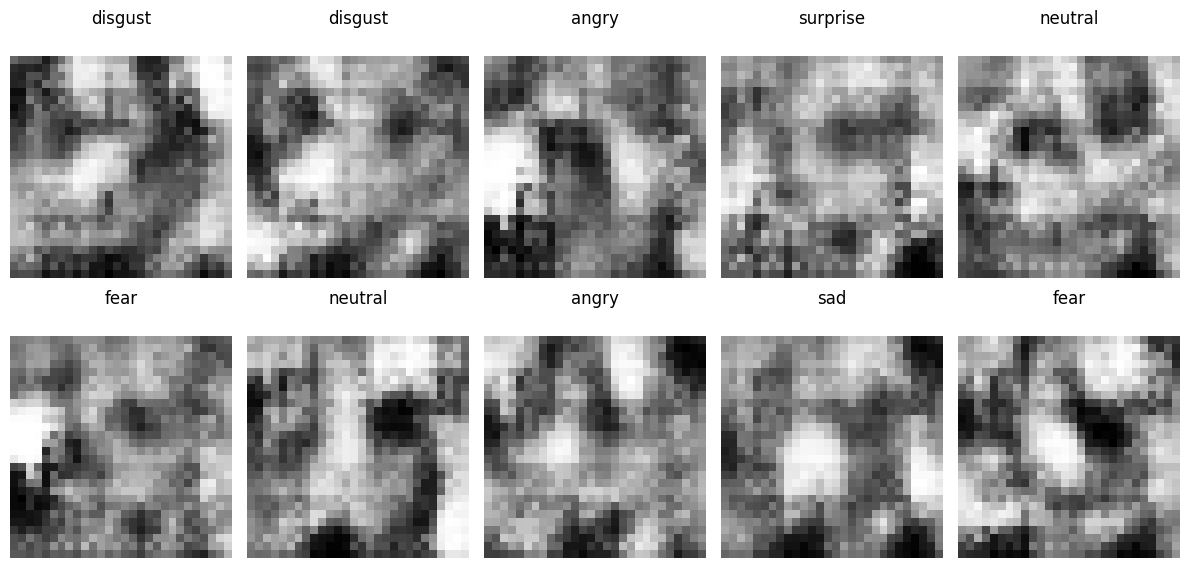

2/2 [==============================] - 0s 3ms/step
Epoch: 1, Batch: 201/225, D_Loss_Real=0.674, D_Loss_Fake=0.701 Gen_Loss=0.826
1/1 [==============================] - 0s 21ms/step


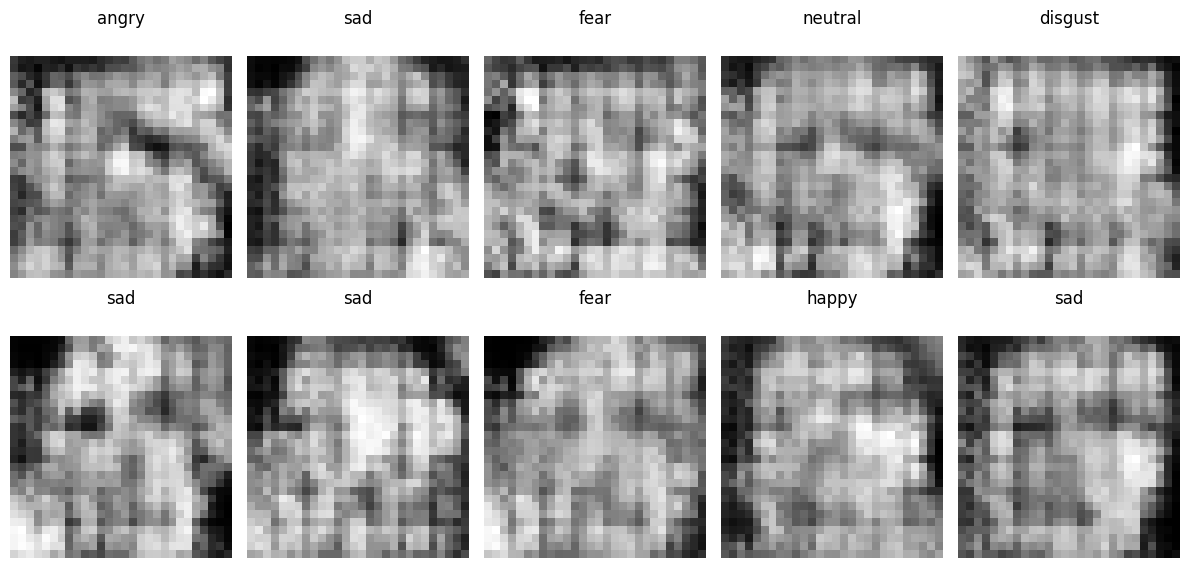

2/2 [==============================] - 0s 4ms/step
Epoch: 2, Batch: 1/225, D_Loss_Real=0.682, D_Loss_Fake=0.786 Gen_Loss=0.886
1/1 [==============================] - 0s 29ms/step


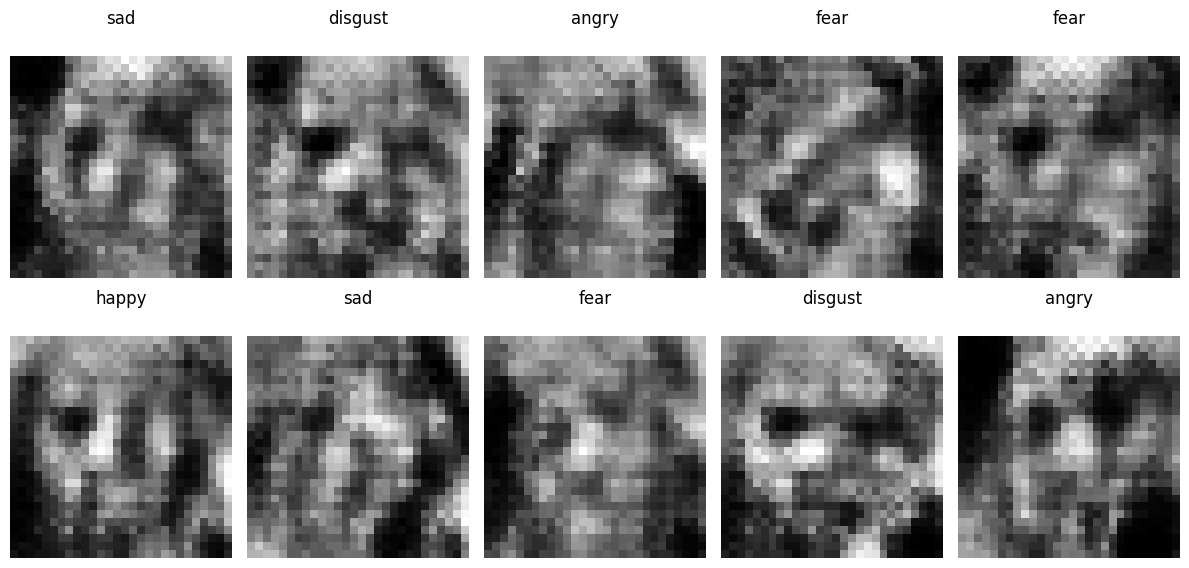

2/2 [==============================] - 0s 4ms/step
Epoch: 2, Batch: 201/225, D_Loss_Real=0.701, D_Loss_Fake=0.616 Gen_Loss=0.993
1/1 [==============================] - 0s 22ms/step


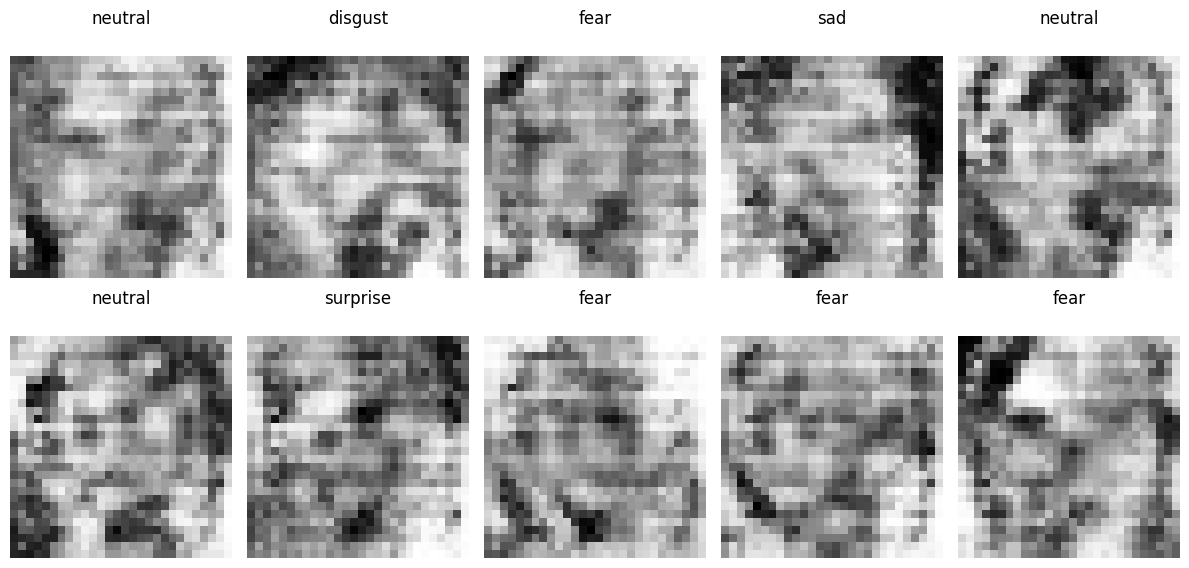

2/2 [==============================] - 0s 4ms/step
Epoch: 3, Batch: 1/225, D_Loss_Real=0.633, D_Loss_Fake=0.713 Gen_Loss=0.720
1/1 [==============================] - 0s 21ms/step


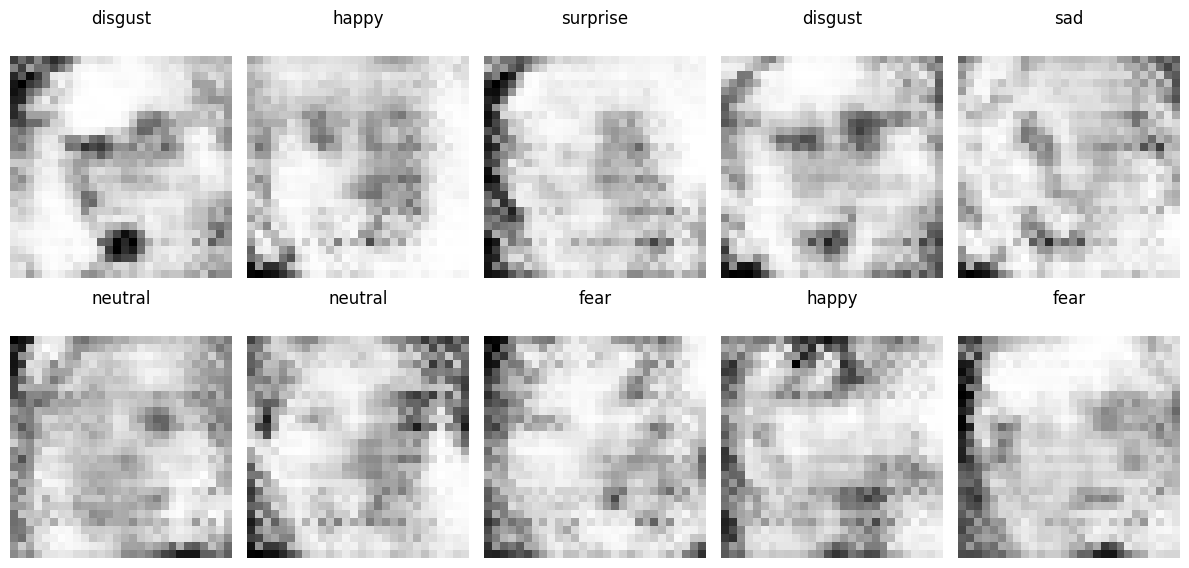

2/2 [==============================] - 0s 4ms/step
Epoch: 3, Batch: 201/225, D_Loss_Real=0.708, D_Loss_Fake=0.727 Gen_Loss=0.944
1/1 [==============================] - 0s 21ms/step


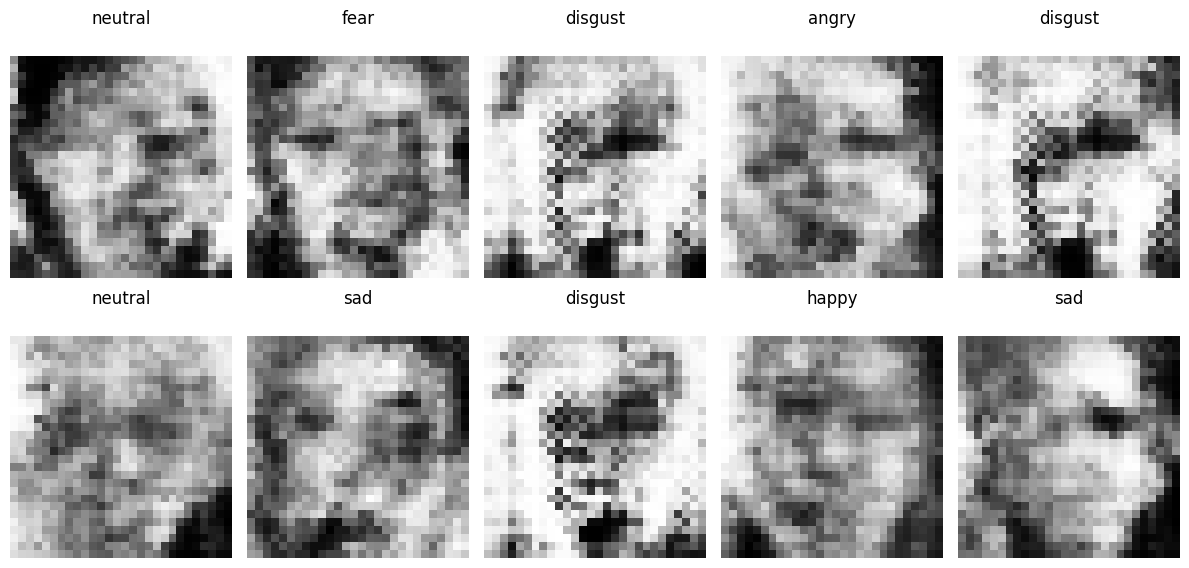

2/2 [==============================] - 0s 3ms/step
Epoch: 4, Batch: 1/225, D_Loss_Real=0.656, D_Loss_Fake=0.726 Gen_Loss=0.815
1/1 [==============================] - 0s 21ms/step


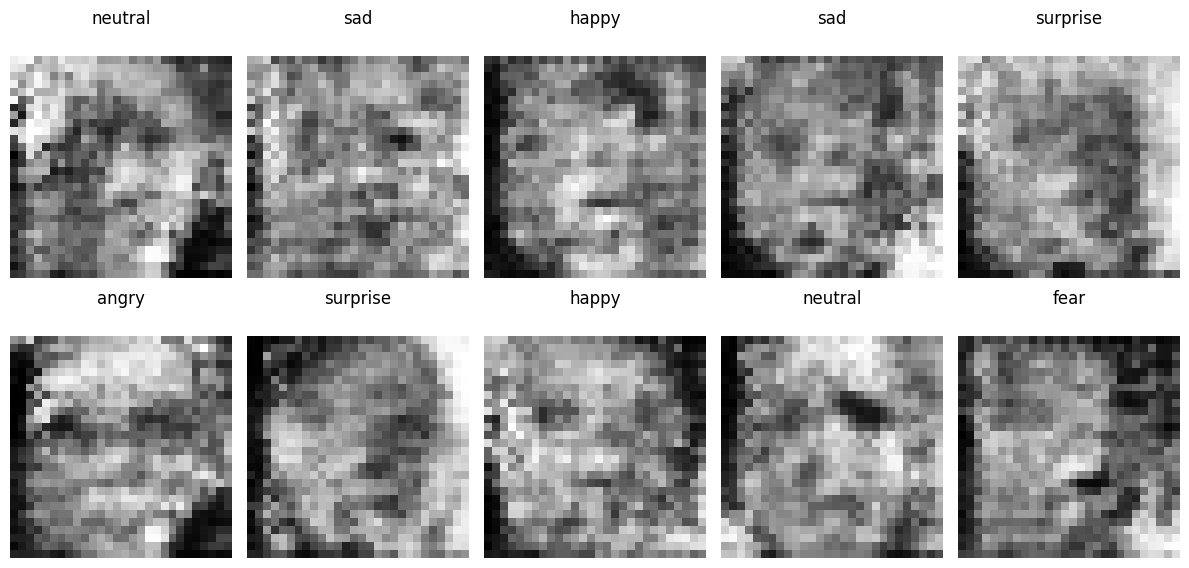

2/2 [==============================] - 0s 4ms/step
Epoch: 4, Batch: 201/225, D_Loss_Real=0.649, D_Loss_Fake=0.590 Gen_Loss=0.962
1/1 [==============================] - 0s 21ms/step


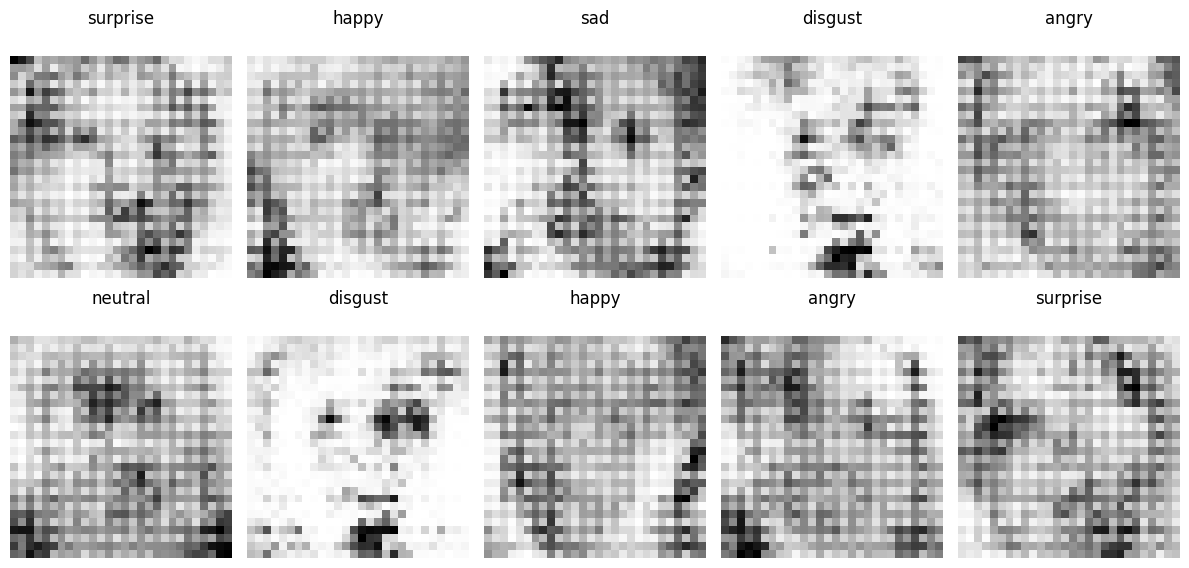

2/2 [==============================] - 0s 4ms/step
Epoch: 5, Batch: 1/225, D_Loss_Real=0.671, D_Loss_Fake=0.646 Gen_Loss=0.867
1/1 [==============================] - 0s 26ms/step


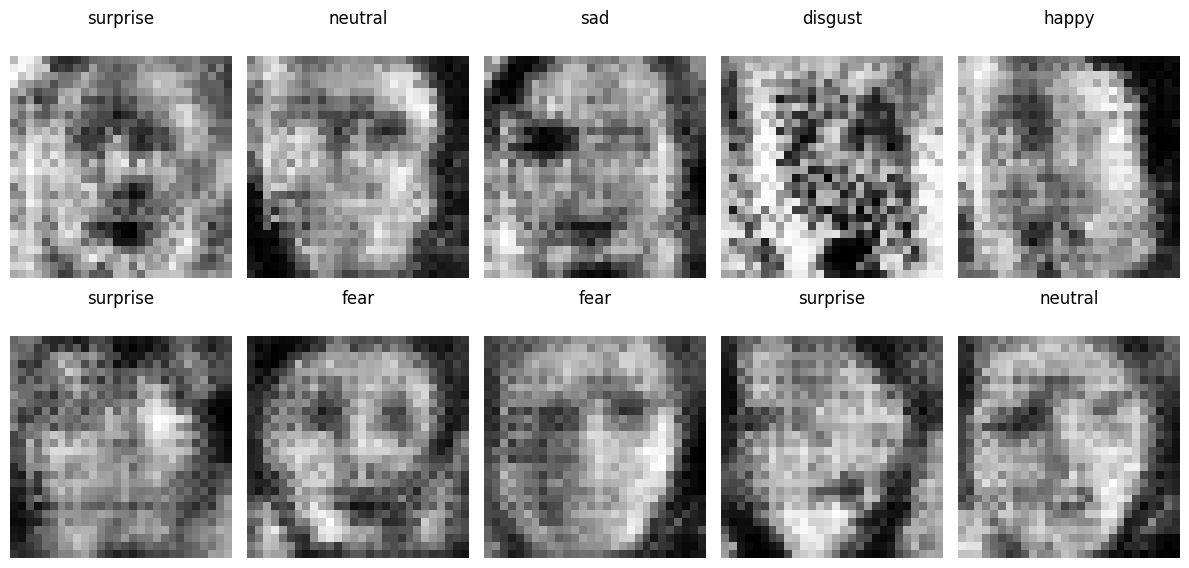

2/2 [==============================] - 0s 4ms/step
Epoch: 5, Batch: 201/225, D_Loss_Real=0.714, D_Loss_Fake=0.641 Gen_Loss=0.857
1/1 [==============================] - 0s 21ms/step


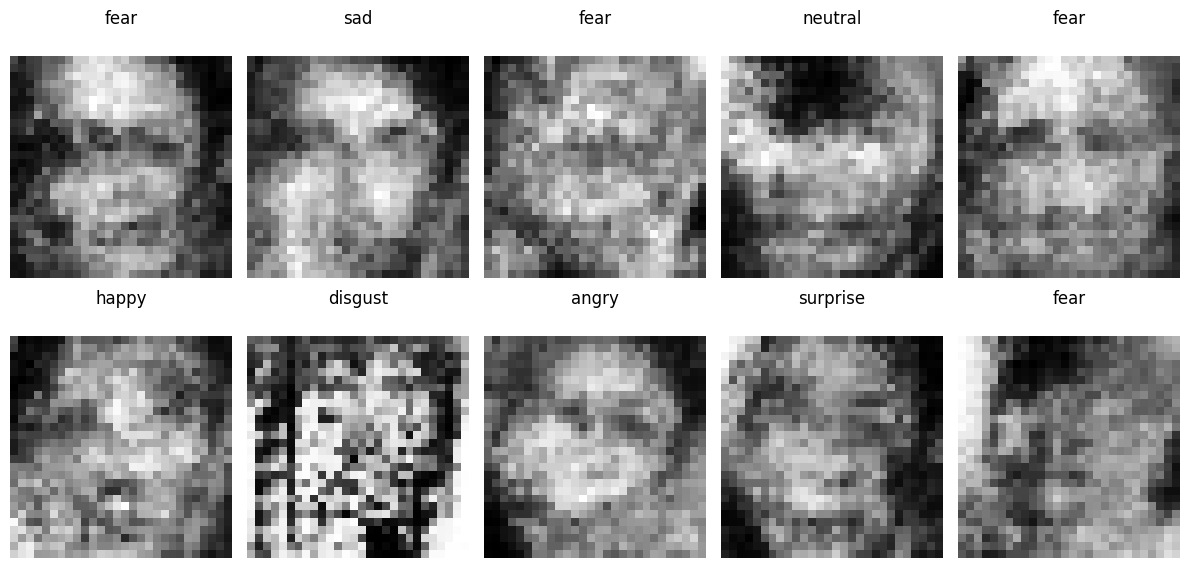

2/2 [==============================] - 0s 4ms/step


In [282]:
train(gen_model, dis_model, gan_model, X_train, y_train, latent_dim)

TEST!